In [1]:
import os
import sys
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

data_path = os.path.join(project_root, "data", "extracted_sentences_and_citations.csv")


# Load the data
try:
    df = pd.read_csv(data_path)
except FileNotFoundError:
    print(f"File not found at absolute path: {os.path.abspath(data_path)}. Make sure to run the extraction script first.")
    df = pd.DataFrame()

if not df.empty:
    # Parse the 'errors' column from JSON strings to lists
    df['errors'] = df['errors'].apply(json.loads)
    print(f"Loaded {len(df)} rows.")

Loaded 8946 rows.


Total paragraphs processed: 8946
Paragraphs with errors: 4194
Failure percentage: 46.88%


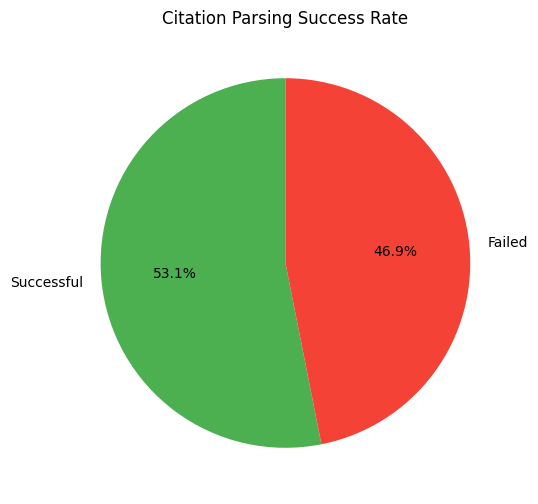

In [2]:
if not df.empty:
    total_rows = len(df)
    rows_with_errors = df[df['errors'].apply(lambda x: len(x) > 0)]
    num_rows_with_errors = len(rows_with_errors)
    failure_percentage = (num_rows_with_errors / total_rows) * 100

    print(f"Total paragraphs processed: {total_rows}")
    print(f"Paragraphs with errors: {num_rows_with_errors}")
    print(f"Failure percentage: {failure_percentage:.2f}%")

    # Plotting the failure rate
    plt.figure(figsize=(6, 6))
    plt.pie([total_rows - num_rows_with_errors, num_rows_with_errors],
            labels=['Successful', 'Failed'],
            autopct='%1.1f%%',
            startangle=90,
            colors=['#4CAF50', '#F44336'])
    plt.title('Citation Parsing Success Rate')
    plt.show()

## Error Analysis

Now, let's categorize the errors to understand the most common failure modes.

In [3]:
# Summarize error categories: print only category counts and list raw messages whose category appears exactly once
import re
import json
from collections import defaultdict, Counter

# Helper ensures rows_with_errors exists
def _ensure_rows_with_errors():
    global rows_with_errors
    if 'rows_with_errors' not in globals() or rows_with_errors is None or rows_with_errors.empty:
        if 'df' in globals() and not df.empty:
            # ensure errors column is parsed to lists
            try:
                df['errors'] = df['errors'].apply(lambda v: json.loads(v) if isinstance(v, str) else (v if isinstance(v, list) else [v] if v is not None else []))
            except Exception:
                df['errors'] = df['errors'].apply(lambda v: v if isinstance(v, list) else ([v] if v is not None else []))
            rows_with_errors = df[df['errors'].apply(lambda x: len(x) > 0)]
        else:
            rows_with_errors = pd.DataFrame()

# Fallback categorization (used only if canonical categorize_error not yet defined)
def categorize_fallback(error_message):
    s = str(error_message) if error_message is not None else ''
    if not s or (isinstance(error_message, float) and np.isnan(error_message)):
        return 'No error'
    if re.search(r'Failed to fetch .*judgment', s, flags=re.IGNORECASE):
        return 'Failed to fetch judgment'
    if re.search(r'Failed to fetch .* for citation', s, flags=re.IGNORECASE):
        return 'Failed to fetch resource for citation'
    s_clean = re.sub(r'\b\d{3,}-\d+\b', '<ID>', s)
    s_clean = re.sub(r'https?://\S+|\bwww\.\S+', '<URL>', s_clean)
    fixed_markers = {
        'Year mismatch':'Year mismatch',
        'Link mismatch':'Link mismatch',
        'unconsumed links':'Unconsumed links',
        'still links in the stripped sentences':'Links in stripped sentences',
        'No ```json block found':'JSON block not found',
        'Invalid JSON format':'Invalid JSON',
        'No paragraphs provided':'No paragraphs in citation',
        'Missing field':'Missing field in citation',
    }
    for marker, label in fixed_markers.items():
        if marker.lower() in s_clean.lower():
            return label
    m = re.match(r"^(.+?)(?:[:\.\-]| for citation| for |$)", s_clean)
    label = m.group(1).strip() if m else s_clean
    if len(label) > 120:
        label = label[:117] + '...'
    return label

# --- run the summary ---
_ensure_rows_with_errors()
if df.empty or rows_with_errors.empty:
    print('No data or no rows with errors available. Run earlier cells to load and parse the dataset.')
else:
    # Choose categorization function
    if 'categorize_error' in globals() and callable(globals()['categorize_error']):
        cat_fn = globals()['categorize_error']
    else:
        cat_fn = categorize_fallback
        print('(Using fallback categorize function; run the cell that defines categorize_error for canonical grouping)')

    # Flatten all error messages
    all_raw_errors = []
    for errs in rows_with_errors['errors']:
        if isinstance(errs, str):
            try:
                errs_parsed = json.loads(errs)
            except Exception:
                errs_parsed = [errs]
        else:
            errs_parsed = errs or []
        for e in errs_parsed:
            if e is None:
                continue
            all_raw_errors.append(str(e))

    # Map each raw error to a category
    cat_for_error = [(cat_fn(e), e) for e in all_raw_errors]
    category_counts = Counter([c for c, _ in cat_for_error])

    print('Error category counts (category -> count):')
    for cat, cnt in category_counts.most_common():
        print(f'- {cat}: {cnt}')

    # Identify categories that appear exactly once and list their underlying raw messages
    singleton_categories = {cat for cat, cnt in category_counts.items() if cnt == 1}
    if singleton_categories:
        print('\nCategories with a single occurrence (showing the raw message for each):')
        # Build mapping cat -> message
        shown = set()
        for cat, raw in cat_for_error:
            if cat in singleton_categories and cat not in shown:
                print(f'* {cat}: {raw}')
                shown.add(cat)
    else:
        print('\nNo singleton categories (every category has multiple occurrences).')


(Using fallback categorize function; run the cell that defines categorize_error for canonical grouping)
Error category counts (category -> count):
- No paragraphs in citation: 5442
- No English translation: 3875
- Year mismatch: 464
- Link mismatch: 429
- Failed to fetch judgment: 385
- Citation extraction error: 202
- Unconsumed links: 197
- Links in stripped sentences: 132
- No metadata: 83
- Extraction error: 2
- Invalid JSON: 1

Categories with a single occurrence (showing the raw message for each):
* Invalid JSON: Invalid JSON: Expecting ':' delimiter: line 153 column 26 (char 14368)


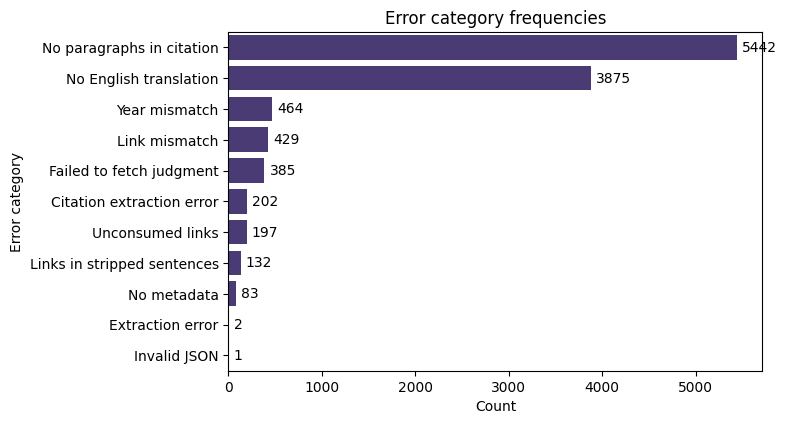

In [4]:
# Bar chart: frequencies of error categories (uses counts from previous cell if available)
from collections import Counter
_ensure_rows_with_errors()
# Prefer the category_counts computed in the earlier cell if present
if 'category_counts' in globals():
    counts = category_counts
else:
    # Recompute robustly from rows_with_errors
    if 'rows_with_errors' not in globals() or rows_with_errors is None or rows_with_errors.empty:
        print('No rows_with_errors available to compute error frequencies.')
        counts = Counter()
    else:
        # choose categorization function if available
        if 'categorize_error' in globals() and callable(globals()['categorize_error']):
            cat_fn = globals()['categorize_error']
        else:
            cat_fn = categorize_fallback
        all_raw_errors = []
        for errs in rows_with_errors['errors']:
            if isinstance(errs, str):
                try:
                    errs_parsed = json.loads(errs)
                except Exception:
                    errs_parsed = [errs]
            else:
                errs_parsed = errs or []
            for e in errs_parsed:
                if e is None:
                    continue
                all_raw_errors.append(str(e))
        cat_for_error = [(cat_fn(e), e) for e in all_raw_errors]
        counts = Counter([c for c, _ in cat_for_error])

if not counts:
    print('No error categories found to plot.')
else:
    import pandas as pd
    df_counts = pd.DataFrame({'category': list(counts.keys()), 'count': list(counts.values())})
    df_counts = df_counts.sort_values('count', ascending=False).reset_index(drop=True)
    plt.figure(figsize=(10, max(4, 0.4 * len(df_counts))))
    prev_palette = sns.color_palette()
    sns.set_palette('viridis')
    ax = sns.barplot(x='count', y='category', data=df_counts)
    sns.set_palette(prev_palette)
    plt.title('Error category frequencies')
    plt.xlabel('Count')
    plt.ylabel('Error category')
    # Annotate bars with counts
    for pos, (_, r) in enumerate(df_counts.iterrows()):
        ax.text(r['count'] + max(1, 0.01 * df_counts['count'].max()), pos, int(r['count']), va='center')
    # Adjust left margin based on the longest category label to avoid tight-layout warnings
    try:
        max_lab_len = df_counts['category'].astype(str).map(len).max()
    except Exception:
        max_lab_len = 20
    left = min(0.6, 0.2 + 0.008 * (max_lab_len if not pd.isna(max_lab_len) else 20))
    plt.subplots_adjust(left=left, right=0.95)
    plt.show()

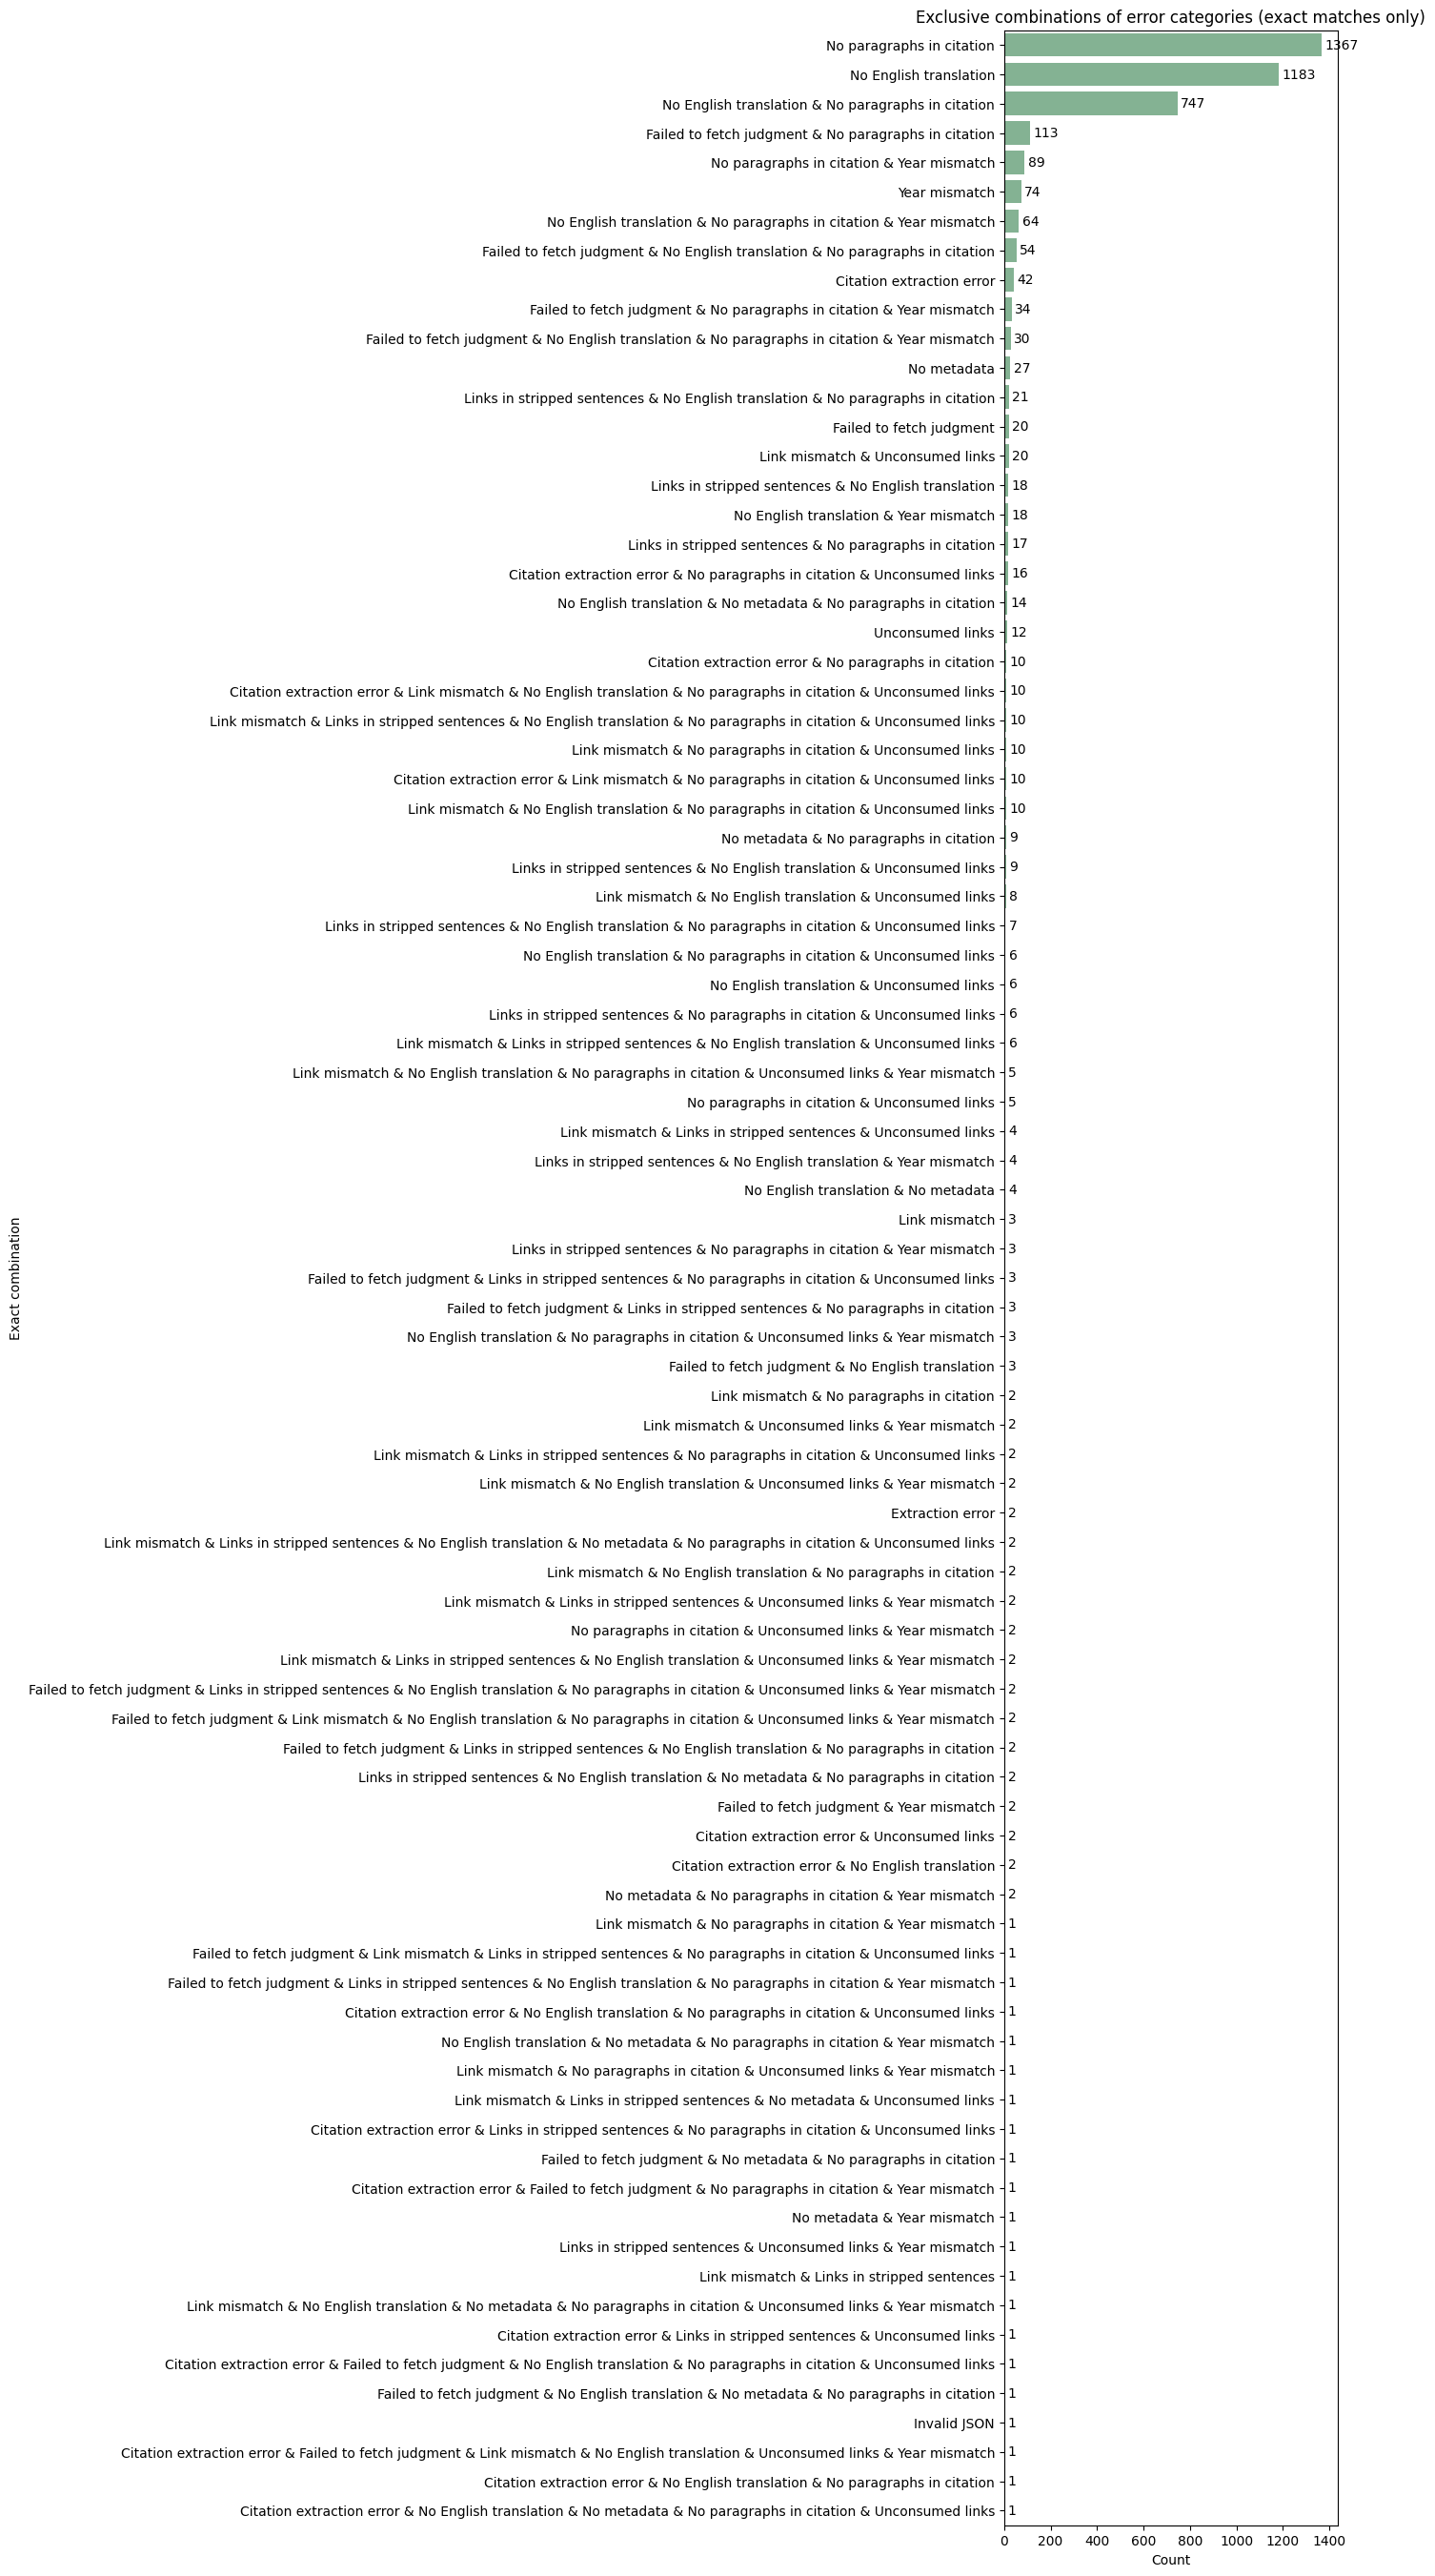


Top combinations and example rows:
- No paragraphs in citation: 1367 rows; example: 
- No English translation: 1183 rows; example: 
- No English translation & No paragraphs in citation: 747 rows; example: 
- Failed to fetch judgment & No paragraphs in citation: 113 rows; example: 
- No paragraphs in citation & Year mismatch: 89 rows; example: 
- Year mismatch: 74 rows; example: 
- No English translation & No paragraphs in citation & Year mismatch: 64 rows; example: 
- Failed to fetch judgment & No English translation & No paragraphs in citation: 54 rows; example: 
- Citation extraction error: 42 rows; example: 
- Failed to fetch judgment & No paragraphs in citation & Year mismatch: 34 rows; example: 
- Failed to fetch judgment & No English translation & No paragraphs in citation & Year mismatch: 30 rows; example: 
- No metadata: 27 rows; example: 
- Links in stripped sentences & No English translation & No paragraphs in citation: 21 rows; example: 
- Failed to fetch judgment: 20 rows;

In [5]:
# Plot exclusive bars for every exact combination of error categories
from collections import Counter
_ensure_rows_with_errors()

if 'rows_with_errors' not in globals() or rows_with_errors is None or rows_with_errors.empty:
    print('No rows_with_errors available to compute combination frequencies.')
else:
    # choose categorization function if available
    if 'categorize_error' in globals() and callable(globals()['categorize_error']):
        cat_fn = globals()['categorize_error']
    else:
        cat_fn = categorize_fallback

    def _normalize_row_errors(errs):
        # Parse string-encoded lists robustly and normalize to a sorted tuple of unique category labels
        if isinstance(errs, str):
            try:
                errs_parsed = json.loads(errs)
            except Exception:
                errs_parsed = [errs]
        else:
            errs_parsed = errs or []
        cats = []
        for e in errs_parsed:
            if e is None:
                continue
            try:
                lab = cat_fn(e) if not isinstance(e, str) else cat_fn(str(e))
            except Exception:
                lab = str(e)
            cats.append(lab)
        # deduplicate and sort for a stable representation; empty -> ()
        return tuple(sorted(set(cats)))

    combo_counter = Counter()
    combo_examples = {}
    # iterate rows and count exact combination matches (tuple equality)
    for idx, errs in rows_with_errors['errors'].items():
        combo = _normalize_row_errors(errs)
        if not combo:
            continue
        combo_counter[combo] += 1
        if combo not in combo_examples:
            # store a short example (if available) for quick inspection
            example = ''
            if 'sentence' in rows_with_errors.columns:
                try:
                    example = str(rows_with_errors.at[idx, 'sentence'])
                except Exception:
                    example = ''
            combo_examples[combo] = example

    # Prepare DataFrame for plotting: label combos as 'A', 'A & B', 'A & B & C' etc.
    import pandas as pd
    combos_sorted = sorted(combo_counter.items(), key=lambda x: x[1], reverse=True)
    df_combo = pd.DataFrame([
        {
            'combo_tuple': combo,
            'combo_label': ' & '.join(combo) if len(combo) > 1 else combo[0],
            'count': cnt
        }
        for combo, cnt in combos_sorted
    ])

    if df_combo.empty:
        print('No exact combinations found to plot.')
    else:
        plt.figure(figsize=(10, max(4, 0.4 * len(df_combo))))
        # Temporarily set the seaborn palette so we don't pass `palette` to barplot (avoids FutureWarning)
        prev_palette = sns.color_palette()
        sns.set_palette('crest')
        ax = sns.barplot(x='count', y='combo_label', data=df_combo)
        sns.set_palette(prev_palette)
        plt.title('Exclusive combinations of error categories (exact matches only)')
        plt.xlabel('Count')
        plt.ylabel('Exact combination')
        for pos, (_, r) in enumerate(df_combo.iterrows()):
            ax.text(r['count'] + max(1, 0.01 * df_combo['count'].max()), pos, int(r['count']), va='center')
        # Adjust left margin based on the longest combo label to avoid tight-layout warnings
        try:
            max_lab_len = df_combo['combo_label'].astype(str).map(len).max()
        except Exception:
            max_lab_len = 20
        left = min(0.6, 0.2 + 0.008 * (max_lab_len if not pd.isna(max_lab_len) else 20))
        plt.subplots_adjust(left=left, right=0.95)
        plt.show()

        # Print a few examples per top combinations for inspection
        print('\nTop combinations and example rows:')
        for combo, cnt in combos_sorted[:20]:
            label = ' & '.join(combo) if len(combo) > 1 else combo[0]
            ex = combo_examples.get(combo, '')
            print(f'- {label}: {cnt} rows; example: {ex[:200] if ex else ''}')